import the necessary packages

In [1]:
from urllib.request import urlopen
import time
import requests
import bs4 as bs
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request

in the first step, we take the links of the teams of the league we are interested in from the transfermarkt

In [2]:
def teamsLink_NB2():
    url = 'https://www.transfermarkt.com/nemzeti-bajnoksag-ii-/startseite/wettbewerb/UN2'
    
    headers = {'USER-AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
    r = requests.get(url,headers=headers)
    soup = bs.BeautifulSoup(r.content, "html.parser")
    # we search based on href
    a_tags = soup.find_all('a', href=True)
    
    tagok = []
    for tag in a_tags:
            if 'startseite' in tag['href']:
                if 'verein' in tag['href']:
                    play = 'https://www.transfermarkt.com'+tag['href']
                    if play not in tagok:
                        tagok.append(play)
                        
    teamsName = [x.text.strip() for x in soup.find_all('td',{'class':"hauptlink no-border-links"})]
    
    teljes_csapat_href = {p:v for p,v in zip(teamsName,tagok)}
    
    return teljes_csapat_href

In [3]:
tLink = teamsLink_NB2()

In [4]:
tLink

{'MTK Budapest': 'https://www.transfermarkt.com/mtk-budapest/startseite/verein/634/saison_id/2022',
 'Diósgyőri VTK': 'https://www.transfermarkt.com/diosgy%C5%91ri-vtk/startseite/verein/9241/saison_id/2022',
 'Gyirmót FC Győr': 'https://www.transfermarkt.com/gyirmot-fc-gy%C5%91r/startseite/verein/22610/saison_id/2022',
 'ETO FC Győr': 'https://www.transfermarkt.com/eto-fc-gy%C5%91r/startseite/verein/6055/saison_id/2022',
 'Szeged-Csanád - GA': 'https://www.transfermarkt.com/szeged-csanad-ga/startseite/verein/30660/saison_id/2022',
 'Budafoki MTE': 'https://www.transfermarkt.com/budafoki-mte/startseite/verein/28410/saison_id/2022',
 'Nyíregyháza Spartacus': 'https://www.transfermarkt.com/nyiregyhaza-spartacus/startseite/verein/6058/saison_id/2022',
 'Szombathelyi Haladás': 'https://www.transfermarkt.com/szombathelyi-haladas/startseite/verein/649/saison_id/2022',
 'Pécsi MFC': 'https://www.transfermarkt.com/pecsi-mfc/startseite/verein/3233/saison_id/2022',
 'Békéscsaba 1912 Elöre SE': 'h

------------------------
we are preparing to scrape the players' link

In [5]:
def souppP(url):
    
    headers = {'USER-AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
    r = requests.get(url,headers=headers)
    soup = bs.BeautifulSoup(r.content, "html.parser")
    
    return soup

In [6]:
def players_href(url):   #url => team URL
    
    sauce = souppP(url)
    
    tagok = []
    a_tags = sauce.find_all('a', href=True)
    # similar to teams function
    for tag in a_tags:
            if 'profil' in tag['href']:
                play = 'https://www.transfermarkt.com'+[tag['href']][0]
                if play not in tagok:
                    tagok.append(play)
    nevek = [x.text for x in sauce.find_all('span',{'class':"hide-for-small"}) if len(x.text) !=0]

    teljes_csapat_href = {p:v for p,v in zip(nevek,tagok)}
    
    return teljes_csapat_href

check

In [7]:
players_href(list(tLink.values())[13])  # we extract a teams URL from dictionary (this is a complicated form, sorry)

{'Dániel Horváth': 'https://www.transfermarkt.com/daniel-horvath/profil/spieler/287512',
 'István Szabados': 'https://www.transfermarkt.com/istvan-szabados/profil/spieler/515758',
 'Márton Balogh': 'https://www.transfermarkt.com/marton-balogh/profil/spieler/188737',
 'Bence Jagodics': 'https://www.transfermarkt.com/bence-jagodics/profil/spieler/234481',
 'Zsolt Tar': 'https://www.transfermarkt.com/zsolt-tar/profil/spieler/152057',
 'Dávid Görgényi': 'https://www.transfermarkt.com/david-gorgenyi/profil/spieler/113420',
 'Ádám Présinger': 'https://www.transfermarkt.com/adam-presinger/profil/spieler/110750',
 'Gyula Csemer': 'https://www.transfermarkt.com/gyula-csemer/profil/spieler/286171',
 'Gergely Tóth': 'https://www.transfermarkt.com/gergely-toth/profil/spieler/188727',
 'Kristóf Szűcs': 'https://www.transfermarkt.com/kristof-sz%C5%B1cs/profil/spieler/487458',
 'Péter Fodor': 'https://www.transfermarkt.com/peter-fodor/profil/spieler/884978',
 'Tamás Tajthy': 'https://www.transfermark

---------------------------------
players' careers - based on Transfermarkt data

In [9]:
def transferRout(url,playersHref): # url=> player URL;  dictionary for all players on the team 
    
    # headers = {'USER-AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
    # r = requests.get(url,headers=headers)
    # soup = bs.BeautifulSoup(r.content, "html.parser")
    soup = souppP(url)
    
    name = [x for x in playersHref if playersHref[x] == url][0]
    
    teams = [ x.text.strip() for x in soup.find_all(name=['span','a'], attrs={'class':"tm-player-transfer-history-grid__club-link"})]
    season = [x.text.strip() for x in soup.find_all('div',{'class':"grid__cell grid__cell--center tm-player-transfer-history-grid__season"})]
    date = [int(x.text.strip().split(',')[1].strip())  for x in soup.find_all('div',{'class':"grid__cell grid__cell--center tm-player-transfer-history-grid__date"})]
    born = int([x.text.strip().split(',')[1].split('(')[0].strip() for x in soup.find_all('span',{'itemprop':"birthDate"})][0])
    year = [x-born for x in date]
    #print(f'name: {len(name)}, teams: {len(teams)}, season: {len(season)}'     )
    fromAtoB = [(season[ind],date[ind],year[ind],name,teams[x],teams[x+1]) for ind, x in enumerate(range(0,len(teams),2))]
    
    return fromAtoB

In [37]:
# sample players
teams_link = list(tLink.values())
team_link = teams_link[13] #we choices the 13th team now
team_players_with_link = players_href(team_link)
team_players_only_link = list(team_players_with_link.values())
player_link = team_players_only_link[1]#chosen player'link - now 1st

#-------------------------------------------------------------------

transferRout(player_link,team_players_with_link)

#transferRout(list(players_href(list(tLink.values())[13]).values())[1], players_href(list(tLink.values())[13]))

[('21/22', 2021, 24, 'István Szabados', 'Debrecen', 'FC Ajka'),
 ('20/21', 2021, 24, 'István Szabados', 'Debreceni EAC', 'Debrecen'),
 ('20/21', 2020, 23, 'István Szabados', 'Debrecen', 'Debreceni EAC'),
 ('20/21', 2020, 23, 'István Szabados', 'Debreceni EAC', 'Debrecen'),
 ('18/19', 2018, 21, 'István Szabados', 'Debrecen', 'Debreceni EAC'),
 ('17/18', 2017, 20, 'István Szabados', 'Debrecen II', 'Debrecen'),
 ('16/17', 2017, 20, 'István Szabados', 'Debrecen U19', 'Debrecen II'),
 ('14/15', 2014, 17, 'István Szabados', 'Debrecen U17', 'Debrecen U19'),
 ('12/13', 2012, 15, 'István Szabados', 'Debrecen Yth.', 'Debrecen U17')]

---------------------------
organizing/collecting within the team (simple for loop)

In [44]:
aggreg = []

for pin in team_players_only_link:
    print(pin)
    kp = transferRout(pin,team_players_with_link)
    aggreg = aggreg+kp

https://www.transfermarkt.com/daniel-horvath/profil/spieler/287512
https://www.transfermarkt.com/istvan-szabados/profil/spieler/515758
https://www.transfermarkt.com/marton-balogh/profil/spieler/188737
https://www.transfermarkt.com/bence-jagodics/profil/spieler/234481
https://www.transfermarkt.com/zsolt-tar/profil/spieler/152057
https://www.transfermarkt.com/david-gorgenyi/profil/spieler/113420
https://www.transfermarkt.com/adam-presinger/profil/spieler/110750
https://www.transfermarkt.com/gyula-csemer/profil/spieler/286171
https://www.transfermarkt.com/gergely-toth/profil/spieler/188727
https://www.transfermarkt.com/kristof-sz%C5%B1cs/profil/spieler/487458
https://www.transfermarkt.com/peter-fodor/profil/spieler/884978
https://www.transfermarkt.com/tamas-tajthy/profil/spieler/157666
https://www.transfermarkt.com/zoltan-kenderes/profil/spieler/141504
https://www.transfermarkt.com/benjamin-nagy/profil/spieler/979191
https://www.transfermarkt.com/balint-vogyicska/profil/spieler/263384
htt

In [48]:
aggreg[:10] # check

[('17/18', 2018, 22, 'Dániel Horváth', 'Csákvár', 'FC Ajka'),
 ('17/18', 2017, 21, 'Dániel Horváth', 'ETO FC Győr', 'Csákvár'),
 ('16/17', 2017, 21, 'Dániel Horváth', 'Kozármisleny', 'ETO FC Győr'),
 ('16/17', 2017, 21, 'Dániel Horváth', 'ETO FC Győr', 'Kozármisleny'),
 ('14/15', 2015, 19, 'Dániel Horváth', 'ETO FC Győr II', 'ETO FC Győr'),
 ('13/14', 2013, 17, 'Dániel Horváth', 'Győr U19', 'ETO FC Győr II'),
 ('12/13', 2013, 17, 'Dániel Horváth', 'Győr U17', 'Győr U19'),
 ('12/13', 2012, 16, 'Dániel Horváth', 'Győr Yth.', 'Győr U17'),
 ('07/08', 2008, 12, 'Dániel Horváth', 'Haladás Yth.', 'Győr Yth.'),
 ('21/22', 2021, 24, 'István Szabados', 'Debrecen', 'FC Ajka')]

write a function on it - all team

In [52]:
def teamsDataFrame(urlPlayers):   #players URL
    start = time.time()
    pl_url = list(urlPlayers.values())
    
    sasa = []
    for pin in pl_url:
        kp = transferRout(pin,urlPlayers)
        sasa = sasa+kp
    
    df = pd.DataFrame({'season':[x[0] for x in sasa],'year':[x[1] for x in sasa],'age':[x[2] for x in sasa],'name':[x[3] for x in sasa],'out':[x[4] for x in sasa],'in':[x[5] for x in sasa]})
    end = time.time()
    print(f'It lasted {round(end-start,2)} seconds.....')
    return df

pre-check with a team, plus timing

In [50]:
%%time
teamsDataFrame(players_href(list(tLink.values())[1]))

29.8
CPU times: user 2.94 s, sys: 78.3 ms, total: 3.02 s
Wall time: 32.2 s


,season,year,age,name,out,in
0,22/23,2023,20,Zsombor Senkó,Juve Next Gen,Diósgyőr
1,22/23,2022,19,Zsombor Senkó,Juventus U19,Juve Next Gen
2,20/21,2020,17,Zsombor Senkó,Juventus U17,Juventus U19
3,19/20,2019,16,Zsombor Senkó,Juventus Youth,Juventus U17
4,18/19,2019,16,Zsombor Senkó,Haladás Yth.,Juventus Youth
...,...,...,...,...,...,...
228,17/18,2017,17,Kristóf Korbély,Diósgyőr U17,Diósgyőr U19
229,16/17,2016,16,Kristóf Korbély,Diósgyőr Yth.,Diósgyőr U17
230,12/13,2012,12,Kristóf Korbély,KBSC Yth.,Diósgyőr Yth.
231,22/23,2023,21,Moussango Obounet,FK Slutsk,Diósgyőr


we put it in a DataFrame

In [53]:
df = pd.DataFrame()
num = 1
for think in range(len(tLink)):
    
    teams_deep = players_href(list(tLink.values())[think])
    
    df = pd.concat([df,teamsDataFrame(teams_deep)])
    print(f'{num}. team is DONE')
    num += 1

It lasted 27.19 seconds.....
1. team is DONE
It lasted 29.71 seconds.....
2. team is DONE
It lasted 27.7 seconds.....
3. team is DONE
It lasted 25.26 seconds.....
4. team is DONE
It lasted 32.87 seconds.....
5. team is DONE
It lasted 34.43 seconds.....
6. team is DONE
It lasted 28.91 seconds.....
7. team is DONE
It lasted 30.09 seconds.....
8. team is DONE
It lasted 22.01 seconds.....
9. team is DONE
It lasted 29.61 seconds.....
10. team is DONE
It lasted 28.03 seconds.....
11. team is DONE
It lasted 28.6 seconds.....
12. team is DONE
It lasted 29.82 seconds.....
13. team is DONE
It lasted 24.72 seconds.....
14. team is DONE
It lasted 25.99 seconds.....
15. team is DONE
It lasted 26.38 seconds.....
16. team is DONE
It lasted 27.13 seconds.....
17. team is DONE
It lasted 24.19 seconds.....
18. team is DONE
It lasted 23.74 seconds.....
19. team is DONE
It lasted 23.49 seconds.....
20. team is DONE


Check

In [54]:
df.reset_index(drop=True, inplace=True)

In [55]:
df

,season,year,age,name,out,in
0,22/23,2023,28,Gergő Rácz,MTK Budapest,Paksi FC
1,22/23,2023,28,Gergő Rácz,Paksi FC,MTK Budapest
2,16/17,2016,21,Gergő Rácz,Ferencváros II,Paksi FC
3,14/15,2015,20,Gergő Rácz,Soroksár,Ferencváros II
4,14/15,2014,19,Gergő Rácz,Ferencváros II,Soroksár
...,...,...,...,...,...,...
4317,19/20,2019,19,Zoárd Nagy,Vasas FC,Taksony SE
4318,18/19,2019,19,Zoárd Nagy,Vasas U19,Vasas FC
4319,17/18,2017,17,Zoárd Nagy,Vasas U17,Vasas U19
4320,16/17,2016,16,Zoárd Nagy,Vasas Yth.,Vasas U17


let's organize the names a bit -> the youth teams of the same team under a collective youth name (unfortunately it is meticulous)

In [56]:
teamsTwist = {'AKA Rapid':['AKA Rapid U15','AKA Rapid U16','AKA Rapid U18',],
              'Ajax UP':['Ajax U17','Ajax U19',],
              'Ajka UP':['FC Ajka Jgd.','FC Ajka U19','Ajka U17',],
              'Augsburg UP':['FC Augsburg II','FC Augsburg U17','FC Augsburg U19',],
              'Atalanta UP':['Atalanta U17','Atalanta U19',],
              'Benfica UP':['Benfica U19','Benfica U23',],
              'Budafok UP':['Budafok II','Budafok Jgd.','Budafok U17','Budafok U19',],
              'Békéscsaba UP':['Békéscsaba II','Békéscsaba U17','Békéscsaba U19','Békéscsaba Yth.',],
              'Cegléd UP':[ 'Cegléd Jgd','Ceglédi VSE U19',],
              'Csákvár UP':['Csákvár II','Csákvár Jgd.','Csákvár U17','Csákvár U19',],
              'Csepel UP':['Csepel FC Jgd','Csepel FC U19',],
              'Debrecen UP':[ 'Debrecen II','Debrecen U17','Debrecen U19','Debrecen Yth.',],
              'Diósgyőr UP':['Diósgyőr II','Diósgyőr U17','Diósgyőr U19','Diósgyőr Yth.',],
              'Dorog UP':['Dorog Jgd.','Dorog U17','Dorog U19',],
              'Dunaújváros':['Dunaujvaros FC','Dunaújváros',],
              'Dunaújváros UP':['Dunaujvaros U19', 'Dunaújváros U19',],
              'Győr':['ETO FC Győr',],
              'Győr UP':['ETO FC Győr II','Győr U17','Győr U19','Győr Yth.',],
              'Fehérvár':['Vidi FC','Videoton FC','Fehérvár',],
              'Fehérvár UP':['Fehérvár II','Fehérvár U17','Fehérvár U19','Fehérvár Yth.', 'Videoton II','Videoton Jgd.','Videoton U17','Videoton U19',],
              'Ferencváros UP':[ 'Ferencváros II','Ferencváros U17','Ferencváros U19','Ferencváros Yth',],
              'Gyirmót UP':[ 'Gyirmót II','Gyirmót U17','Gyirmót U19','Gyirmót Yth.',],
              'Haladás UP':[ 'Haladás II','Haladás U17','Haladás U19','Haladás Yth.',],
              'Honvéd UP':['Honvéd II','Honvéd U17','Honvéd U19','Honvéd Yth.',],
              'Juventus UP':['Juventus U17','Juventus U19','Juventus Youth',],
              'Kozármisleny UP':['K.misleny U17','K.misleny Yth.',],
              'Kazincbarcika UP':['KBSC U17','KBSC U19','KBSC Yth.',],
              'Kaposvár UP':['Kaposvár II','Kaposvár U17','Kaposvár U19','Kaposvár Yth.',],
              'Kecskemét UP':['Kecskemét II','Kecskemét Jgd','Kecskemét U17', 'Kecskemét U19','Kecskemét Yth.',],
              'Kecskemét':['Kecskeméti TE',],
              'Kisvárda UP':['Kisvárda II','Kisvárda Jgd.','Kisvárda U17','Kisvárda U19',],
              'Liverpool UP':['Liverpool Res.','Liverpool U18','Liverpool U21','Liverpool U23',],
              'MTE UP':['MTE 1904 U17','MTE 1904 U19','MTE1904 II','MTE1904 Jgd',],
              'MTK UP':[ 'MTK Budapest II','MTK U17','MTK U19','MTK Yth.',],
              'Mezőkövesd UP':[ 'Mezőkövesd II','Mezőkövesd U19',],
              'Nyíregyháza UP':[ 'Ny.háza Yth.','Nyíregyháza II','Nyíregyháza U17','Nyíregyháza U19',],
              'PSV UP':['PSV Eindhoven Y','PSV U17','PSV U19','PSV U21',],
              'Paks UP':[ 'Paksi FC II','Paksi FC U17','Paksi FC U19','Paksi FC Yth.',],
              'Puskás UP':['Puskás AFC II','Puskás AFC U17','Puskás AFC U19','Puskás AFC Yth.','Felcsút U19'],
              'Pécs UP':[ 'Pécsi MFC II','Pécsi MFC U17','Pécsi MFC U19','Pécsi MFC Yth.',],
              'REAC UP':['REAC Jgd.','REAC U19',],
              'Rapid UP':['Rapid U15','Rapid U17','Rapid U19',],
              'Siófok UP':['Siofok U19','Siófok U17','Siófok Yth.',],
              'Szeged UP':['Szeged II','Szeged Jgd - GA','Szeged U17 - GA','Szeged U19 - GA',],
              'Szolnok UP':[ 'Szolnok U17','Szolnok U19','Szolnok Yth.','Szolnoki MÁV FC II',],
              'Tatabánya UP':[ 'Tatabánya U19','Tatabányai Jgd',],
              'Tiszakécske UP':['Tiszakecske Jgd','Tiszakécske II','Tiszakécske U19','T.Kécske U17',],
              'Vasas UP':['Vasas FC II','Vasas II','Vasas Jgd.','Vasas U17','Vasas U19','Vasas Yth.',],
              'Vác UP':['Vác U17','Vác U19','Vác Yth.',],
              'Zalaegerszeg UP':[ 'ZTE U17','ZTE U19','ZTE Youth','Zalaegerszeg II',],
              'Újpest UP':[ 'Újpest II','Újpest U17','Újpest U19','Újpest Yth.'],
              'Újpest':['Újpest','Újpest FC',],
              'Veszprém UP':['Veszprém U17','Veszprém Yth.',]
}

function to rewrite the team names

In [57]:
def nameD(dictionary,dataFrame):
    csnevek, uzuni = [],{}
    végső = {}
    
    for tu in dictionary.values():
        for tz in tu:
            csnevek.append(tz)
    
    gm = [x for x in dataFrame.out.unique()]
    for t in dataFrame['in'].unique():
        if t not in gm:
            gm.append(t)
    
    for t in csnevek:
        név = [x for x in dictionary if t in dictionary[x]][0]
        uzuni[t] = név
    
    for p in gm:
        if p in uzuni.keys():
            végső[p] = uzuni[p]
        else:
            végső[p] = p
    
    sd = pd.DataFrame({'t1':uzuni.keys(),'t2':uzuni.values()})
    
    tE = [x for x in sd.t1.unique()]
    cs2 = {}
    for kul in gm:
        if kul not in tE:
            cs2[kul] = kul
    
    sd2 = pd.DataFrame(({'t1':cs2.keys(),'t2':cs2.values()}))
    
    sdMer = {*sd,*sd2}
    sd10 = pd.concat([sd,sd2]).reset_index(drop=True)
    
    return sd10

we apply the function and check, that's why we make two new columns

In [58]:
df2 = nameD(teamsTwist,df)
dFrame2 = (df
        .assign(new_team=[df2[df2.t1 == x].t2.values[0] for x in df.out],
           old_team=[df2[df2.t1 == x].t2.values[0] for x in df['in']]))

In [59]:
dFrame2

,season,year,age,name,out,in,new_team,old_team
0,22/23,2023,28,Gergő Rácz,MTK Budapest,Paksi FC,MTK Budapest,Paksi FC
1,22/23,2023,28,Gergő Rácz,Paksi FC,MTK Budapest,Paksi FC,MTK Budapest
2,16/17,2016,21,Gergő Rácz,Ferencváros II,Paksi FC,Ferencváros UP,Paksi FC
3,14/15,2015,20,Gergő Rácz,Soroksár,Ferencváros II,Soroksár,Ferencváros UP
4,14/15,2014,19,Gergő Rácz,Ferencváros II,Soroksár,Ferencváros UP,Soroksár
...,...,...,...,...,...,...,...,...
4317,19/20,2019,19,Zoárd Nagy,Vasas FC,Taksony SE,Vasas FC,Taksony SE
4318,18/19,2019,19,Zoárd Nagy,Vasas U19,Vasas FC,Vasas UP,Vasas FC
4319,17/18,2017,17,Zoárd Nagy,Vasas U17,Vasas U19,Vasas UP,Vasas UP
4320,16/17,2016,16,Zoárd Nagy,Vasas Yth.,Vasas U17,Vasas UP,Vasas UP


groupby because of the determination of the weights - with the new names now

In [60]:
n2 = dFrame2.groupby(['old_team','new_team']).size().reset_index(name='w')

exclude 'Without Club' value

In [61]:
n2 = n2[(n2.new_team!='Without Club')&(n2.old_team!='Without Club')].reset_index(drop=True)

In [62]:
n2

,old_team,new_team,w
0,1.FC K'lautern,Hamburger SV,1
1,1.FC Köln II,1.FC Köln U19,1
2,1.FC Köln U19,Königsdorf U19,1
3,1.FC Nuremberg,Hamburger SV,1
4,1.FSV Mainz 05,Alem. Aachen,1
...,...,...,...
2110,Újpest UP,REAC UP,1
2111,Újpest UP,Tompai SE,1
2112,Újpest UP,Vasas UP,3
2113,Újpest UP,Zalaegerszeg UP,1


we want an undirected network, so we define the weights accordingly - the column name is useless (hahaha)

In [67]:
def lastClean_to_Graph(dataFrame):
    
    összeF = {}
    # two cases
    for jim in range(len(dataFrame)):
        
        aT, bT = dataFrame.loc[jim].old_team,dataFrame.loc[jim].new_team
        if aT == bT: #first case
            
            tb = dataFrame[(dataFrame.old_team == aT) & (dataFrame.new_team == aT)]
            # sub cases
            if len(tb)==1:
                val = tb.w.values[0]
                
            if(len(tb))>1:
                val = sum(tb.w)
                
        if aT != bT: #second case
            
            tb = dataFrame[((dataFrame.old_team == aT) | (dataFrame.new_team == aT)) & ((dataFrame.old_team == bT) | (dataFrame.new_team == bT))]
            val = sum(tb.w)
            
        if ((aT,bT) not in összeF) & ((bT,aT) not in összeF):
            
            összeF[(aT,bT)] = val

    df = pd.DataFrame({'new':[x[0] for x in összeF],'old':[x[1] for x in összeF],'weight':[összeF[x] for x in összeF]})
    
    df = df.sort_values('weight',ascending=False).reset_index(drop=True)
    
    return df

In [65]:
df_to_edge = lastClean_to_Graph(n2)

In [68]:
df_to_edge

,new,old,weight
0,MTK UP,MTK UP,116
1,Puskás UP,Puskás UP,87
2,Honvéd UP,Honvéd UP,68
3,Haladás UP,Haladás UP,67
4,Ferencváros UP,Ferencváros UP,59
...,...,...,...
1593,Haladás UP,Nagykanizsa Jgd,1
1594,Haladás UP,Nyíregyháza UP,1
1595,Haladás UP,Vasas UP,1
1596,Haladás UP,Újpest UP,1


In [78]:
# make a dictionary from df_to_edge

In [79]:
def edges_(dataFrame):
    
    edges = {}
    
    for x in range(len(dataFrame)):
        
        w = dataFrame.iloc[x].weight
        edge = '\t'.join([dataFrame.iloc[x].old,dataFrame.iloc[x].new])
        
        if edge not in edges:
            edges[edge] = w
        else:
            edges[edge] += w
            
    return edges

In [80]:
edges = edges_(df_to_edge)

## NetworkX_now
we write a function due to NetworkX

In [81]:
def dRawGraph(dataFrame):
    
    G = nx.Graph()
    
    for e, w in edges.items(): # sort the connected edges and add weights
        
        if w>0:
            e1, e2 = e.split('\t')

            G.add_edge(e1, e2, weight=w)

    G.remove_edges_from(nx.selfloop_edges(G))

    print('Number of nodes: ', G.number_of_nodes())
    print('Number of edges: ', G.number_of_edges())
    
    return G

In [82]:
G = dRawGraph(df_to_edge)

Number of nodes:  507
Number of edges:  1554


drawing...

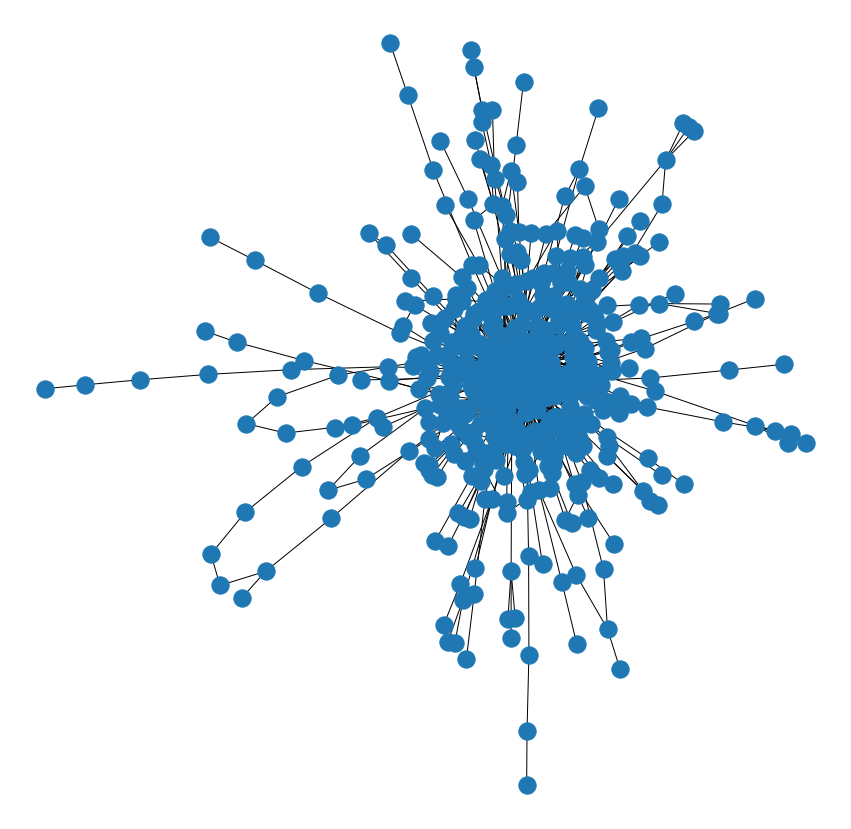

In [83]:
f, ax = plt.subplots(1,1,figsize=(15,15))
nx.draw(G, ax=ax)

for further use, we save it in a format suitable for Gephi

In [84]:
nx.write_gexf(G, 'NB2_transferMarktData_.gexf')

characteristics of our network (idea from @milanJanosov)

In [85]:
# get the node degree distribution
nodes = sorted([(k, v) for k, v in dict(G.degree).items()], key=lambda tup: tup[1], reverse = True)
print('Top 10 most connected teams:', ', '.join([n[0] for n in nodes[0:10]]))

print('\n\nNumber of connections of the top teams:\n')
szm = 0
for n in nodes[0:10]:
    print(n[0], n[1])
    szm+=n[1]
# compute the number of links belonging to the top characters
print('\n\nFraction of connections relating to the top 10 teams:' , round(sum([n[1] for n in nodes[0:10]])/sum([n[1] for n in nodes]), 3))

Top 10 most connected teams: MTK UP, Ferencváros UP, Győr, Honvéd UP, Nyíregyháza, MTK Budapest, Diósgyőr, Mezőkövesd, Kazincbarcika, Haladás


Number of connections of the top teams:

MTK UP 60
Ferencváros UP 60
Győr 55
Honvéd UP 54
Nyíregyháza 53
MTK Budapest 50
Diósgyőr 50
Mezőkövesd 48
Kazincbarcika 47
Haladás 46


Fraction of connections relating to the top 10 teams: 0.168


In [86]:
for limit in [10, 5, 3]:
    print('Connection limit: ' + str(limit) + ', number of nodes: ', len([n for n in nodes if n[1]<limit]), len(nodes))

Connection limit: 10, number of nodes:  437 507
Connection limit: 5, number of nodes:  386 507
Connection limit: 3, number of nodes:  313 507


In [88]:
edges = sorted([(' - '.join(sorted([e[0], e[1]])), G.get_edge_data(e[0], e[1])['weight']) for e in G.edges], key=lambda tup: tup[1], reverse = True)
for ind, edge in enumerate(edges):
    if ind<10:
        print(ind+1, edge)

1 ('Csákvár - Puskás UP', 51)
2 ('Csákvár - Puskás AFC', 44)
3 ('MTK Budapest - MTK UP', 38)
4 ('Ferencváros - Soroksár', 29)
5 ('Fehérvár UP - Puskás UP', 26)
6 ('Haladás - Haladás UP', 25)
7 ('Ferencváros UP - Soroksár', 25)
8 ('Fehérvár UP - Puskás AFC', 20)
9 ('Kozármisleny - Pécsi MFC', 18)
10 ('Puskás AFC - Puskás UP', 16)


In [160]:
a = [x[0].split('-')[0].strip() for x in edges]
b = [x[0].split('-')[1].strip() for x in edges]
c = [x[1] for x in edges]

In [161]:
ddk = pd.DataFrame({'a':a,'b':b,'edg':c})

In [162]:
dp = ddk.groupby('edg').size().reset_index(name='val')

In [163]:
dp.sample()

,edg,val
6,7,20


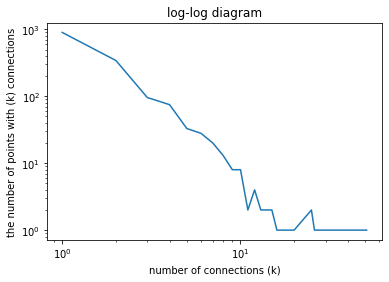

In [164]:
plt.loglog(dp.edg,dp.val)
plt.xlabel('number of connections (k)')
plt.ylabel('the number of points with (k) connections')
plt.title('log-log diagram');

In [165]:
import seaborn as sns

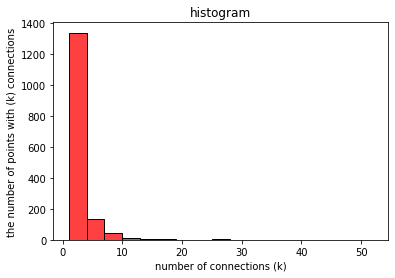

In [166]:
sns.histplot(ddk.edg,color='r',binwidth=3)
plt.xlabel('number of connections (k)')
plt.ylabel('the number of points with (k) connections')
plt.title('histogram');